In [77]:
from scipy.optimize import minimize
import pandas as pd
import numpy as np

df = pd.read_excel("spx_returns_weekly.xlsx", sheet_name="s&p500 rets")
df2 = pd.read_excel("spx_returns_weekly.xlsx", sheet_name="benchmark rets")
df = df.set_index("date").join(df2.set_index("date"), how="inner")[["AAPL", "NVDA", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "AVGO", "BRK/B", "LLY", "SPY"]]
df.head()

,AAPL,NVDA,MSFT,GOOGL,AMZN,META,TSLA,AVGO,BRK/B,LLY,SPY
date,,,,,,,,,,,
2015-01-09,0.024514,-0.009315,0.009195,-0.054445,-0.037534,-0.009055,-0.057685,0.047971,0.002011,-0.001855,-0.005744
2015-01-16,-0.053745,0.000836,-0.020131,0.019448,-0.020880,-0.032931,-0.065760,-0.010268,-0.001739,0.010726,-0.012827
2015-01-23,0.065950,0.037578,0.020329,0.061685,0.074431,0.035255,0.042575,0.030500,-0.000603,0.020514,0.016565
2015-01-30,0.036997,-0.072636,-0.143706,-0.008130,0.134900,-0.024669,0.011476,-0.038331,-0.034938,-0.001802,-0.026931
2015-02-06,0.019114,0.062269,0.049753,-0.006812,0.055737,-0.018967,0.067589,0.018037,0.043569,-0.022778,0.030584


In [99]:
import math
TARGET_MEAN = 0.2
FREQ = 52
cov = df.cov() * FREQ
mean = df.mean() * FREQ
vol = df.std() * math.sqrt(FREQ)
sharpe = mean / vol

In [100]:
vol

AAPL     0.276629
NVDA     0.463283
MSFT     0.239980
GOOGL    0.279851
AMZN     0.306000
META     0.351336
TSLA     0.586431
AVGO     0.375132
BRK/B    0.190654
LLY      0.282980
SPY      0.170877
dtype: float64

In [79]:
mean

AAPL     0.238714
NVDA     0.645580
MSFT     0.261402
GOOGL    0.216800
AMZN     0.293447
META     0.261924
TSLA     0.469754
AVGO     0.394854
BRK/B    0.135025
LLY      0.281542
SPY      0.131264
dtype: float64

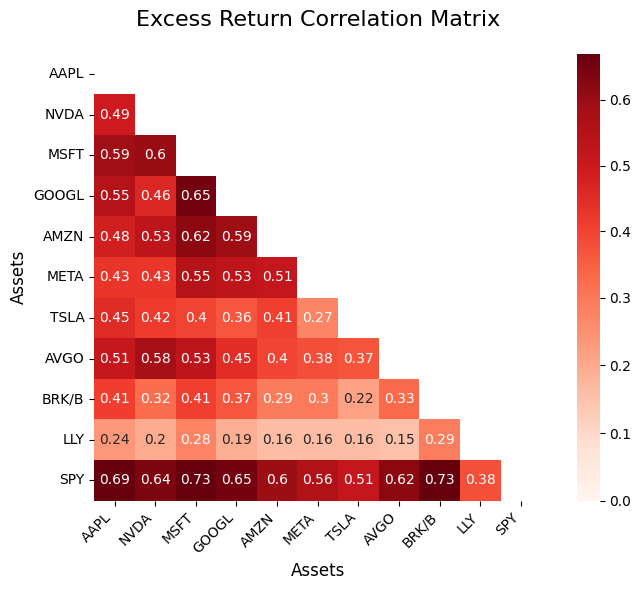

In [80]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
corr_matrix = df.corr()

"""
Copied from Mark's Notebook
"""

# Create figure with better styling
plt.figure(figsize=(8, 6))

# Set upper triangle and diagonal to NaN for cleaner visualization
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix_masked = corr_matrix.copy()
corr_matrix_masked[mask.astype(bool)] = np.nan

# Set up color normalization
center = 0.33
vmin = 0
vmax = 0.67
norm = TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)

# Create heatmap
sns.heatmap(corr_matrix_masked, 
            annot=True,# No annotations
            norm=norm, 
            cmap='Reds', 
    cbar=True,
    square=True)

plt.title('Excess Return Correlation Matrix', fontsize=16, pad=20)
plt.xlabel('Assets', fontsize=12)
plt.ylabel('Assets', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [81]:
def objective(w):        
    return (w.T @ cov @ w)

def fun_constraint_capital(w):
    return np.sum(w) - 1

def fun_constraint_mean(w):
    return (mean @ w) - TARGET_MEAN

In [82]:
constraint_capital = {'type': 'eq', 'fun': fun_constraint_capital}
constraint_mean = {'type': 'eq', 'fun': fun_constraint_mean}

constraints = ([constraint_capital, constraint_mean])

TICKS =  ['AAPL','NVDA','MSFT','GOOGL','AMZN','META','TSLA','AVGO','BRK/B','LLY', "SPY"]
bounds = [(-0.2, 0.35) for tick in TICKS]

In [83]:
min_return = mean.min()
max_return = mean.max()
print("Min annualized mean:", min_return)
print("Max annualized mean:", max_return)

Min annualized mean: 0.1312644400898072
Max annualized mean: 0.645580120253181


In [84]:
initial_guess = mean / mean.sum()
result = minimize(objective, method="SLSQP", x0=initial_guess, constraints=constraints, bounds=bounds)
result

     message: Optimization terminated successfully
     success: True
      status: 0
         fun: 0.027188165547000178
           x: [ 2.968e-02 -1.346e-02  1.441e-01  9.599e-03  9.382e-02
                2.706e-03 -1.656e-02  3.644e-02  3.500e-01  2.130e-01
                1.507e-01]
         nit: 19
         jac: [ 5.697e-02  8.264e-02  5.848e-02  5.573e-02  6.058e-02
                5.880e-02  7.100e-02  6.703e-02  4.981e-02  5.966e-02
                5.033e-02]
        nfev: 229
        njev: 19
 multipliers: [ 4.208e-02  6.270e-02]

In [85]:
if result.success:
    weights = result.x
    wdf = pd.DataFrame({"bounded": weights}, index=TICKS)
    cmean = mean @ weights
    cvol = np.sqrt(objective(weights))
    csharpe = cmean / cvol
    print(f"constrained mean: {cmean:.2f}")
    print(f"constrained vol: {cvol:.2f}")
    print(f"constrained sharpe: {csharpe:.2f}")

constrained mean: 0.20
constrained vol: 0.16
constrained sharpe: 1.21


In [86]:
mean

AAPL     0.238714
NVDA     0.645580
MSFT     0.261402
GOOGL    0.216800
AMZN     0.293447
META     0.261924
TSLA     0.469754
AVGO     0.394854
BRK/B    0.135025
LLY      0.281542
SPY      0.131264
dtype: float64

In [87]:
sharpe

AAPL     0.862938
NVDA     1.393490
MSFT     1.089266
GOOGL    0.774698
AMZN     0.958976
META     0.745509
TSLA     0.801039
AVGO     1.052574
BRK/B    0.708223
LLY      0.994919
SPY      0.768182
dtype: float64

In [88]:
# 1b
cdf = pd.DataFrame({"weights": weights * 100, "sharpe": sharpe}, index=TICKS)
cdf["mean"] = mean.loc[TICKS]
cdf = cdf.sort_values(by="weights", ascending=False)
cdf

,weights,sharpe,mean
BRK/B,35.000000,0.708223,0.135025
LLY,21.302623,0.994919,0.281542
SPY,15.065314,0.768182,0.131264
MSFT,14.410676,1.089266,0.261402
AMZN,9.382347,0.958976,0.293447
AVGO,3.643719,1.052574,0.394854
AAPL,2.967713,0.862938,0.238714
GOOGL,0.959947,0.774698,0.216800
META,0.270580,0.745509,0.261924
NVDA,-1.346443,1.393490,0.645580


In [89]:
cdf.sort_values(by="sharpe", ascending=False)

,weights,sharpe,mean
NVDA,-1.346443,1.393490,0.645580
MSFT,14.410676,1.089266,0.261402
AVGO,3.643719,1.052574,0.394854
LLY,21.302623,0.994919,0.281542
AMZN,9.382347,0.958976,0.293447
AAPL,2.967713,0.862938,0.238714
TSLA,-1.656475,0.801039,0.469754
GOOGL,0.959947,0.774698,0.216800
SPY,15.065314,0.768182,0.131264
META,0.270580,0.745509,0.261924


In [90]:
cdf.sort_values(by="mean", ascending=False)

,weights,sharpe,mean
NVDA,-1.346443,1.393490,0.645580
TSLA,-1.656475,0.801039,0.469754
AVGO,3.643719,1.052574,0.394854
AMZN,9.382347,0.958976,0.293447
LLY,21.302623,0.994919,0.281542
META,0.270580,0.745509,0.261924
MSFT,14.410676,1.089266,0.261402
AAPL,2.967713,0.862938,0.238714
GOOGL,0.959947,0.774698,0.216800
BRK/B,35.000000,0.708223,0.135025


# 1B
There doesn't seem to be a correlation with sharpe or mean leading to an increase/decrease in weights.

In [91]:
wdf["equal"] = (1 / len(TICKS) ) * 100
wdf["bounded"] *= 100
wdf.head()

,bounded,equal
AAPL,2.967713,9.090909
NVDA,-1.346443,9.090909
MSFT,14.410676,9.090909
GOOGL,0.959947,9.090909
AMZN,9.382347,9.090909


In [92]:
print(f"Sum of weights: {weights.sum()}")
wdf = wdf.round(4)
wdf.sort_values(by="bounded", ascending=False)

Sum of weights: 1.0


,bounded,equal
BRK/B,35.0000,9.0909
LLY,21.3026,9.0909
SPY,15.0653,9.0909
MSFT,14.4107,9.0909
AMZN,9.3823,9.0909
AVGO,3.6437,9.0909
AAPL,2.9677,9.0909
GOOGL,0.9599,9.0909
META,0.2706,9.0909
NVDA,-1.3464,9.0909


In [93]:
cmean

np.float64(0.20000000000040394)

In [94]:
cvol

np.float64(0.16488834266557528)

In [95]:
csharpe

np.float64(1.212942023476103)

In [96]:
ret_df = pd.read_excel("spx_returns_weekly.xlsx", sheet_name="s&p500 rets")
ret_df = ret_df[["AAPL", "NVDA", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "AVGO", "BRK/B", "LLY"]]
df2 = pd.read_excel("spx_returns_weekly.xlsx", sheet_name="benchmark rets")[["SPY"]]
ret_df = ret_df.join(df2)

R = ret_df.values
y = np.ones(R.shape[0])

beta = np.linalg.inv((R.T) @ R) @ (R.T @ y)

w_reg = beta / beta.sum()

wt_reg = pd.Series(w_reg, index=ret_df.columns)
print("Tangency Portfolio Weights (via regression trick):")
print(wt_reg.sort_values(ascending=False))

# annualize mean/covariance
mu = ret_df.mean() * 52           
Sigma = ret_df.cov() * 52

# 
w_mv = np.linalg.inv(Sigma.values) @ mu.values
w_mv = w_mv / w_mv.sum()
ucmean = mu @ w_mv
ucvol = ret_df.std() @ w_mv
ucsharpe = ucmean / ucvol

mu = mu * w_mv
Sigma = Sigma * w_mv
print("\nDo the regression and tangency weights match?")
print(np.allclose(wt_reg.values, w_mv, rtol=1e-5))

Tangency Portfolio Weights (via regression trick):
BRK/B    2.580474
LLY      1.112630
NVDA     0.882896
MSFT     0.848584
AVGO     0.601896
AMZN     0.426356
AAPL     0.409367
TSLA     0.310150
META     0.277408
GOOGL    0.193126
SPY     -6.642887
dtype: float64

Do the regression and tangency weights match?
True


In [97]:
# 1.3
wdf["unbounded"] = w_mv * 100
wdf

,bounded,equal,unbounded
AAPL,2.9677,9.0909,40.936744
NVDA,-1.3464,9.0909,88.289577
MSFT,14.4107,9.0909,84.858406
GOOGL,0.9599,9.0909,19.312564
AMZN,9.3823,9.0909,42.635592
META,0.2706,9.0909,27.740754
TSLA,-1.6565,9.0909,31.014977
AVGO,3.6437,9.0909,60.189647
BRK/B,35.0000,9.0909,258.047389
LLY,21.3026,9.0909,111.263002


In [98]:
print(f"constrained mean: {cmean}")
print(f"constrained vol: {cvol}")
print(f"constrained sharpe: {csharpe}")
print(f"unconstrained mean: {ucmean}")
print(f"unconstrained vol: {ucvol}")
print(f"unconstrained sharpe: {ucsharpe}")

constrained mean: 0.20000000000040394
constrained vol: 0.16488834266557528
constrained sharpe: 1.212942023476103
unconstrained mean: 1.302227634973375
unconstrained vol: 0.15077836298490663
unconstrained sharpe: 8.636700977472026


No, the most extreme positions (BRK/B, LLY, and SPY) do have some of the largest means (Amazon, not included, does have a large mean)

# Unbounded Portfolio Weights